# Imports

In [1]:
import math
import numpy as np
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,confusion_matrix
import os, glob
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, GRU
import tensorflow
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

# import data

In [2]:
def append_dir_data(path, data=[], label=0):
    for filename in glob.glob(os.path.join(path, '*.txt')):
        with open(filename, 'r', encoding="utf8") as f:
            text = f.read()
            data.append([text, label])

    return data



In [ ]:
data = append_dir_data('aclImdb\\train\\pos', label=1)
data = append_dir_data('aclImdb\\train\\neg', data, label=0)
df_train = pd.DataFrame(data, columns=['text', 'label'])

In [ ]:
data_test = append_dir_data('aclImdb\\test\\pos', label=1)
data_test = append_dir_data('aclImdb\\test\\neg', data_test, label=0)
df_test = pd.DataFrame(data_test, columns=['text', 'label'])

In [ ]:
df_train.head(5)

In [ ]:
df_test.head(5)

In [ ]:
df_train = df_train.sample(frac=1)
df_test = df_train.sample(frac=1)
df_train.head(10)

# Part 1

lower case all

In [16]:
df_train['text'] = df_train['text'].apply(lambda x: x.lower())
df_test['text'] = df_test['text'].apply(lambda x: x.lower())
df_train.head(5)

,text,label
9808,"after the glories of the snare, it was unlikel...",1
11947,"a bit slow and boring, the tale of an old man ...",1
13887,visually stunning? most definitely. i have see...,0
17548,"in hazzard county, georgia, cousins bo and luk...",0
13006,i'd give this a negative rating if i could. i ...,0


remove punctuations

In [17]:
df_train['text'] = df_train['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_test['text'] = df_test['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_train.head(5)

,text,label
9808,after the glories of the snare it was unlikely...,1
11947,a bit slow and boring the tale of an old man a...,1
13887,visually stunning most definitely i have seen ...,0
17548,in hazzard county georgia cousins bo and luke ...,0
13006,id give this a negative rating if i could i we...,0


remove URL

In [18]:
df_train['text'] = df_train['text'].apply(lambda x: re.sub(r'http\S+', '', x))
df_test['text'] = df_test['text'].apply(lambda x: re.sub(r'http\S+', '', x))
df_train.head(10)

,text,label
9808,after the glories of the snare it was unlikely...,1
11947,a bit slow and boring the tale of an old man a...,1
13887,visually stunning most definitely i have seen ...,0
17548,in hazzard county georgia cousins bo and luke ...,0
13006,id give this a negative rating if i could i we...,0
3198,this movie is so cheap its endearing with ron ...,1
22497,this movie should have never been made from th...,0
24557,daniella has some issues brewing under her att...,0
14431,the oftenreliable leonard maltin says this is ...,0
12263,the story is being told fluidly there are no i...,1


tokenise

In [19]:
df_train['text'] = df_train['text'].apply(lambda x: word_tokenize(x))
df_test['text'] = df_test['text'].apply(lambda x: word_tokenize(x))
df_train.head(10)

,text,label
9808,"[after, the, glories, of, the, snare, it, was,...",1
11947,"[a, bit, slow, and, boring, the, tale, of, an,...",1
13887,"[visually, stunning, most, definitely, i, have...",0
17548,"[in, hazzard, county, georgia, cousins, bo, an...",0
13006,"[id, give, this, a, negative, rating, if, i, c...",0
3198,"[this, movie, is, so, cheap, its, endearing, w...",1
22497,"[this, movie, should, have, never, been, made,...",0
24557,"[daniella, has, some, issues, brewing, under, ...",0
14431,"[the, oftenreliable, leonard, maltin, says, th...",0
12263,"[the, story, is, being, told, fluidly, there, ...",1


remove stop words

In [20]:
stop_words = set(stopwords.words('english'))

df_train['text'] = df_train['text'].apply(lambda x: [w for w in x if not w.lower() in stop_words])
df_test['text'] = df_test['text'].apply(lambda x: [w for w in x if not w.lower() in stop_words])

df_train.head(5)

,text,label
9808,"[glories, snare, unlikely, outing, hanzo, woul...",1
11947,"[bit, slow, boring, tale, old, man, wife, livi...",1
13887,"[visually, stunning, definitely, seen, films, ...",0
17548,"[hazzard, county, georgia, cousins, bo, luke, ...",0
13006,"[id, give, negative, rating, could, went, movi...",0


stemming

In [21]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

ps = PorterStemmer()

df_train['text'] = df_train['text'].apply(lambda x: [ps.stem(w) for w in x])
df_test['text'] = df_test['text'].apply(lambda x: [ps.stem(w) for w in x])

df_train.head(5)

,text,label
9808,"[glori, snare, unlik, outing, hanzo, would, ab...",1
11947,"[bit, slow, bore, tale, old, man, wife, live, ...",1
13887,"[visual, stun, definit, seen, film, look, good...",0
17548,"[hazzard, counti, georgia, cousin, bo, luke, d...",0
13006,"[id, give, neg, rate, could, went, movi, expec...",0


# Part2 , 3

In [22]:
all_data = df_train.append(df_test)
all_data

C:\Users\KASHANI\AppData\Local\Temp\ipykernel_9992\326838982.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = df_train.append(df_train)


,text,label
9808,"[glori, snare, unlik, outing, hanzo, would, ab...",1
11947,"[bit, slow, bore, tale, old, man, wife, live, ...",1
13887,"[visual, stun, definit, seen, film, look, good...",0
17548,"[hazzard, counti, georgia, cousin, bo, luke, d...",0
13006,"[id, give, neg, rate, could, went, movi, expec...",0
...,...,...
15537,"[pleas, dont, rent, even, think, buy, moviethe...",0
24997,"[saw, descent, last, night, stockholm, film, f...",0
21221,"[dont, quit, get, rate, amati, girl, think, re...",0
22587,"[outsid, fact, georg, lopez, pretenti, jerk, s...",0


In [23]:
lengths = []
for row in all_data['text']:
    lengths.append(len(row))
lengths = np.array(lengths)
lengths.sort()
len(lengths)

50000

In [24]:
sentence_length = lengths[int(len(lengths) * 0.85)]
print(f' selected length for sentences is {sentence_length} ')

 selected length for sentences is 202 


by approximations

In [25]:
sentence_length = 200

In [26]:
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

In [27]:
vector_size = 100
w2v_model = Word2Vec(min_count=1,
                     window=5,
                     vector_size=vector_size,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=8)

In [28]:
w2v_model.build_vocab(all_data['text'], progress_per=10000)

In [29]:
w2v_model.train(all_data['text'], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(108574490, 186249480)

In [30]:
w2v_model.wv.get_vector('good')

array([-1.2771084 ,  0.355467  , -2.0194702 ,  1.1610599 , -0.75614935,
       -0.04691978,  1.639416  ,  0.5164116 , -0.97583634,  0.5115985 ,
        0.19130263,  1.1315086 , -0.24888021,  0.3671351 , -0.5340134 ,
       -0.10083996,  0.5608099 ,  1.0572952 , -0.42155784, -1.6492637 ,
        0.03244184, -0.30316246,  0.5324392 , -1.1263422 , -0.55306494,
       -0.02276744, -1.2123061 ,  0.16956332,  0.5702913 ,  0.49310562,
        0.9360299 , -0.25400665, -0.39335948, -0.5672018 , -0.7277494 ,
        1.0324992 , -1.3892962 ,  0.36219448,  0.77093256,  0.19135252,
        0.08118483,  0.12300646,  0.799915  ,  0.7248231 ,  0.278896  ,
       -0.10797102, -0.07764656, -1.6571534 ,  1.0694411 , -1.2656987 ,
        0.40854958, -0.41537213,  0.10508372,  0.57951474,  0.26977193,
        0.66857225,  0.3300935 ,  0.27961472, -1.8427979 ,  0.8755829 ,
        0.28759712, -1.9567205 ,  1.0798279 , -1.3825198 , -0.906401  ,
       -0.70028275, -0.7954682 ,  0.65704036, -0.6312666 , -0.92

In [31]:
vector_size

100

In [32]:
def make_vector_of_words(df: pd.DataFrame):
    max_iter = sentence_length
    texts = df['text']
    progress = 0
    all_vectors = []

    for row in texts:
        sentence_vectors = []
        progress += 1
        i = 0
        while i < max_iter and i < len(row):
            sentence_vectors.append(w2v_model.wv.get_vector(row[i]))
            i += 1

        # print(f'test ***{progress}')
        while i < max_iter:
            sentence_vectors.append(np.zeros(vector_size))
            i += 1

        if progress % 1000 == 0:
            print(f'progress = {progress * 100 / len(texts)}')

        all_vectors.append(np.array(sentence_vectors))

    all_vectors = np.array(all_vectors)
    return all_vectors

In [33]:
train_vectors = make_vector_of_words(df_train)
train_vectors.shape

progress = 4.0
progress = 8.0
progress = 12.0
progress = 16.0
progress = 20.0
progress = 24.0
progress = 28.0
progress = 32.0
progress = 36.0
progress = 40.0
progress = 44.0
progress = 48.0
progress = 52.0
progress = 56.0
progress = 60.0
progress = 64.0
progress = 68.0
progress = 72.0
progress = 76.0
progress = 80.0
progress = 84.0
progress = 88.0
progress = 92.0
progress = 96.0
progress = 100.0


(25000, 200, 100)

In [34]:
test_vectors = make_vector_of_words(df_test)
test_vectors.shape

progress = 4.0
progress = 8.0
progress = 12.0
progress = 16.0
progress = 20.0
progress = 24.0
progress = 28.0
progress = 32.0
progress = 36.0
progress = 40.0
progress = 44.0
progress = 48.0
progress = 52.0
progress = 56.0
progress = 60.0
progress = 64.0
progress = 68.0
progress = 72.0
progress = 76.0
progress = 80.0
progress = 84.0
progress = 88.0
progress = 92.0
progress = 96.0
progress = 100.0


(25000, 200, 100)

In [35]:
np.save("trainVectors.npy", train_vectors)
np.save("testVectors.npy", test_vectors)
np.save("trainLabel.npy", df_train['label'].to_numpy().reshape(-1, 1))
np.save("testLabel.npy", df_test['label'].to_numpy().reshape(-1, 1))

# part 4

In [2]:
def plot_accuracy_loss(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [3]:
def show_report_model(y_true, pred):
    print(classification_report(y_true, pred))
    print("******")
    cm = confusion_matrix(y_true, pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[0, 1], yticklabels=[0, 1])

    print(f'accuracy model {accuracy_score(y_true, preds) * 100} % \n \n')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    print(f'confusion_matrix \n')
    plt.show(block=False)

## LSTM

load prev part results

In [4]:
train_vectors = np.load("trainVectors.npy")
# test_vectors = np.load("testVectors.npy")
train_labels = np.load("trainLabel.npy")
# test_labels =  np.load("testLabel.npy")

# train_vectors.shape , test_vectors.shape , train_labels.shape, test_labels.shape
train_vectors.shape, train_labels.shape

((25000, 200, 100), (25000, 1))

In [5]:
vector_size = 100

In [6]:
sentence_length = 200

In [7]:
model = Sequential()
model.add(keras.Input(shape=(sentence_length, vector_size)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200, return_sequences=False)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 200, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200, 400)         481600    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 200, 400)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 400)         961600    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 200, 400)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 400)              9

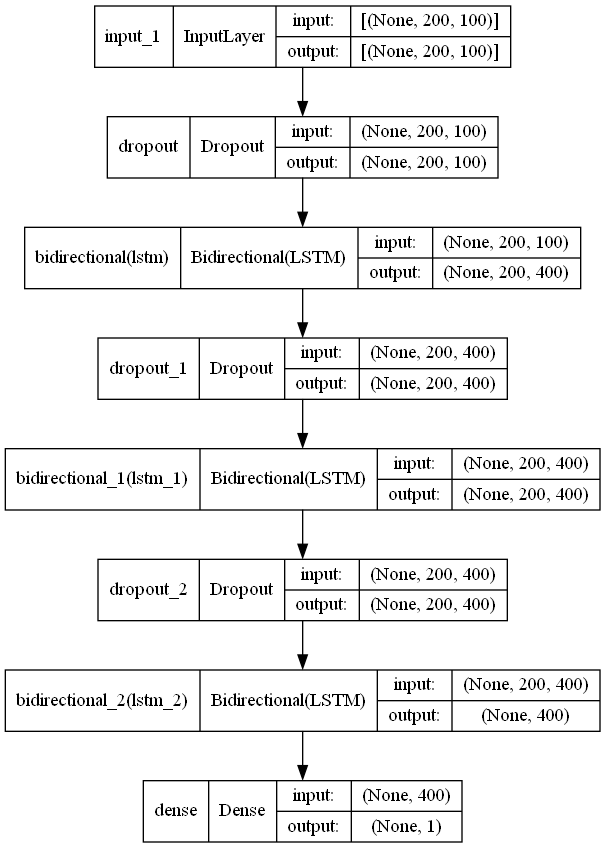

In [8]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

In [9]:
history = model.fit(train_vectors, train_labels, batch_size=64, epochs=5, validation_split=0.1)

Epoch 1/5
352/352 [==============================] - 44s 102ms/step - loss: 0.4469 - accuracy: 0.7950 - val_loss: 0.3624 - val_accuracy: 0.8440
Epoch 2/5
352/352 [==============================] - 35s 99ms/step - loss: 0.3394 - accuracy: 0.8604 - val_loss: 0.3127 - val_accuracy: 0.8628
Epoch 3/5
352/352 [==============================] - 35s 98ms/step - loss: 0.3045 - accuracy: 0.8748 - val_loss: 0.3168 - val_accuracy: 0.8712
Epoch 4/5
352/352 [==============================] - 35s 99ms/step - loss: 0.2828 - accuracy: 0.8844 - val_loss: 0.2879 - val_accuracy: 0.8748
Epoch 5/5
352/352 [==============================] - 35s 98ms/step - loss: 0.2681 - accuracy: 0.8916 - val_loss: 0.2993 - val_accuracy: 0.8736


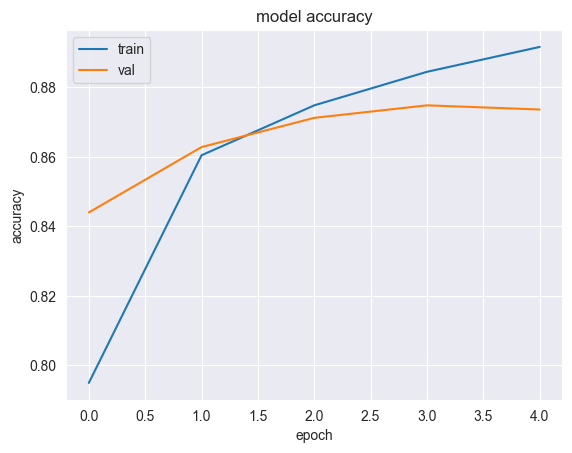

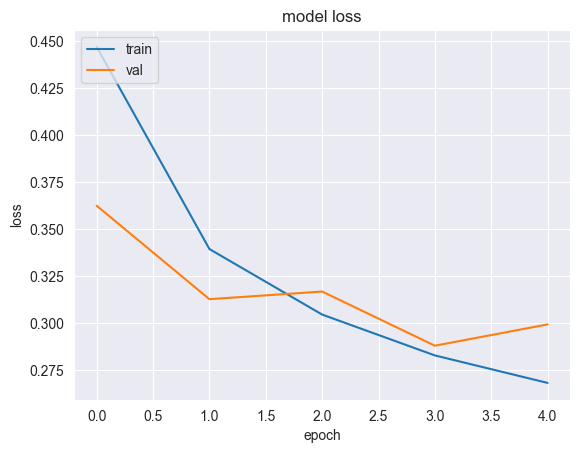

In [10]:
plot_accuracy_loss(history)

save model

In [11]:
model.save_weights("weights2/lstm/lstm_weights")
model.save('lstm_model2.h5')

load model

In [4]:
savedModel = load_model('lstm_model2.h5')
savedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 200, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200, 400)         481600    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 200, 400)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 400)         961600    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 200, 400)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 400)              9

In [5]:
test_vectors = np.load("testVectors.npy")
test_labels = np.load("testLabel.npy")

# train_vectors.shape , test_vectors.shape , train_labels.shape, test_labels.shape
test_vectors.shape, test_labels.shape

((25000, 200, 100), (25000, 1))

In [6]:
preds = savedModel.predict(test_vectors)

In [7]:
preds = [0 if row < 0.50 else 1 for row in preds]
preds

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,


              precision    recall  f1-score   support

           0       0.87      0.94      0.91     12500
           1       0.94      0.86      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.91      0.90      0.90     25000
weighted avg       0.91      0.90      0.90     25000

******
accuracy model 90.256 % 
 

confusion_matrix 



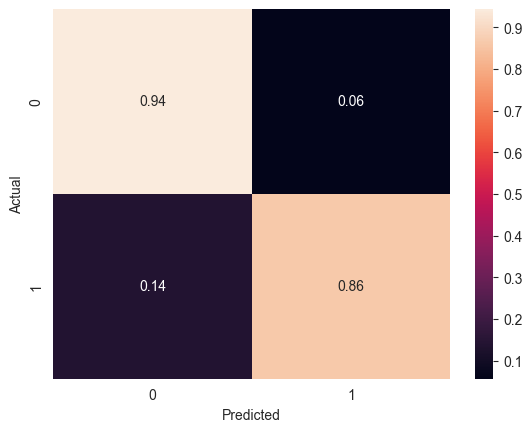

In [8]:
show_report_model(test_labels, preds)

## GRU

In [4]:
train_vectors = np.load("trainVectors.npy")
train_labels = np.load("trainLabel.npy")

train_vectors.shape, train_labels.shape

((25000, 200, 100), (25000, 1))

In [5]:
vector_size = 100
sentence_length = 200

In [6]:
model = Sequential()
model.add(keras.Input(shape=(sentence_length, vector_size)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(200, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(200, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(200, return_sequences=False)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 200, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200, 400)         362400    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 200, 400)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 400)         722400    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 200, 400)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 400)              7

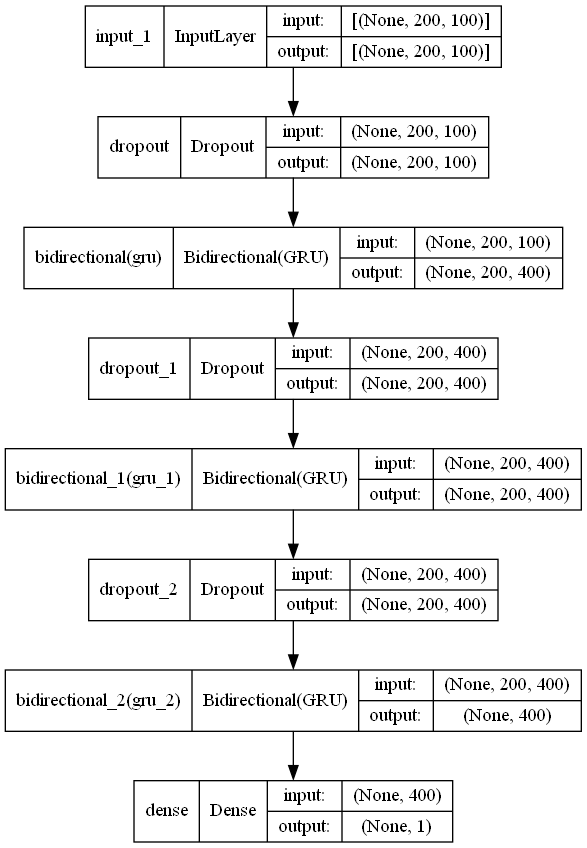

In [7]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

In [8]:
history = model.fit(train_vectors, train_labels, batch_size=64, epochs=3, validation_split=0.1)

Epoch 1/3
352/352 [==============================] - 32s 74ms/step - loss: 0.4035 - accuracy: 0.8195 - val_loss: 0.3544 - val_accuracy: 0.8616
Epoch 2/3
352/352 [==============================] - 25s 70ms/step - loss: 0.2895 - accuracy: 0.8780 - val_loss: 0.2882 - val_accuracy: 0.8776
Epoch 3/3
352/352 [==============================] - 25s 70ms/step - loss: 0.2600 - accuracy: 0.8932 - val_loss: 0.2670 - val_accuracy: 0.8916


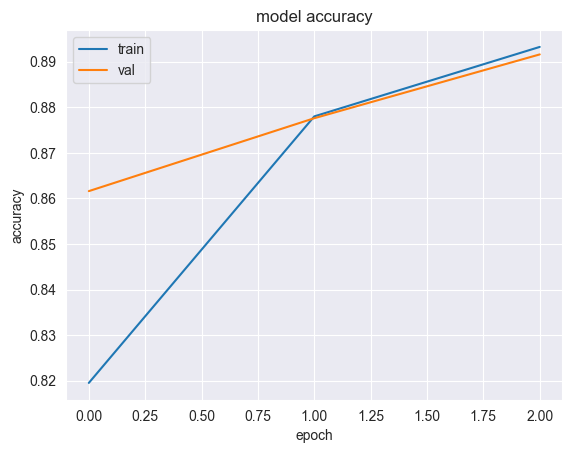

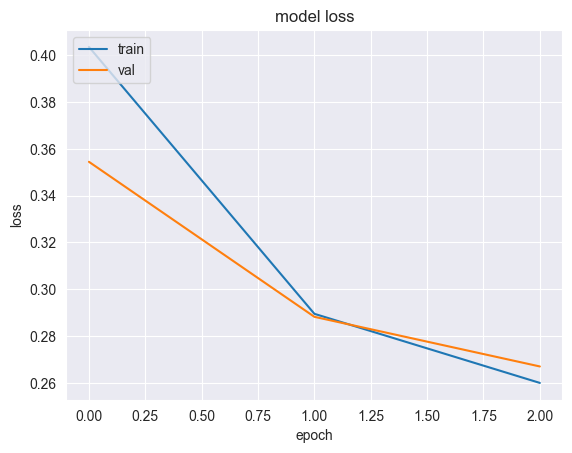

In [9]:
plot_accuracy_loss(history)

save model

In [10]:
model.save_weights("weights2/gru/gru_weights")
model.save('gru_model2.h5')

load model

In [4]:
savedModel = load_model('gru_model2.h5')
savedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 200, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200, 400)         362400    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 200, 400)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 400)         722400    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 200, 400)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 400)              7

In [5]:
test_vectors = np.load("testVectors.npy")
test_labels = np.load("testLabel.npy")

# train_vectors.shape , test_vectors.shape , train_labels.shape, test_labels.shape
test_vectors.shape, test_labels.shape

((25000, 200, 100), (25000, 1))

In [6]:
preds = savedModel.predict(test_vectors)
preds = [0 if row < 0.50 else 1 for row in preds]
preds

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,


              precision    recall  f1-score   support

           0       0.92      0.92      0.92     12500
           1       0.92      0.92      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000

******
accuracy model 92.072 % 
 

confusion_matrix 



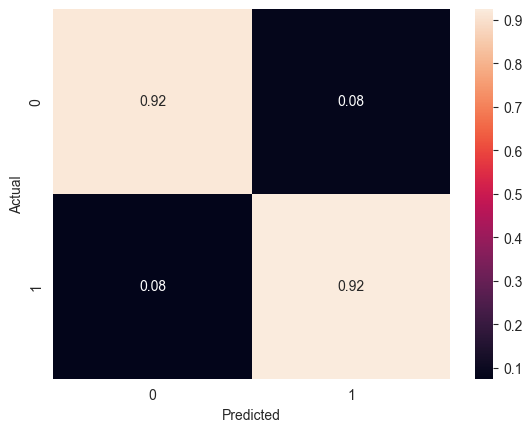

In [7]:
show_report_model(test_labels, preds)

# Extra part

In [4]:
train_vectors = np.load("trainVectors.npy")
train_labels = np.load("trainLabel.npy")

train_vectors.shape, train_labels.shape

((25000, 200, 100), (25000, 1))

In [5]:
vector_size = 100
sentence_length = 200
model = Sequential()
model.add(keras.Input(shape=(sentence_length, vector_size,1)))
model.add(Dropout(0.2))
model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 200, 100, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 100, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 50, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 50, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 25, 64)        1

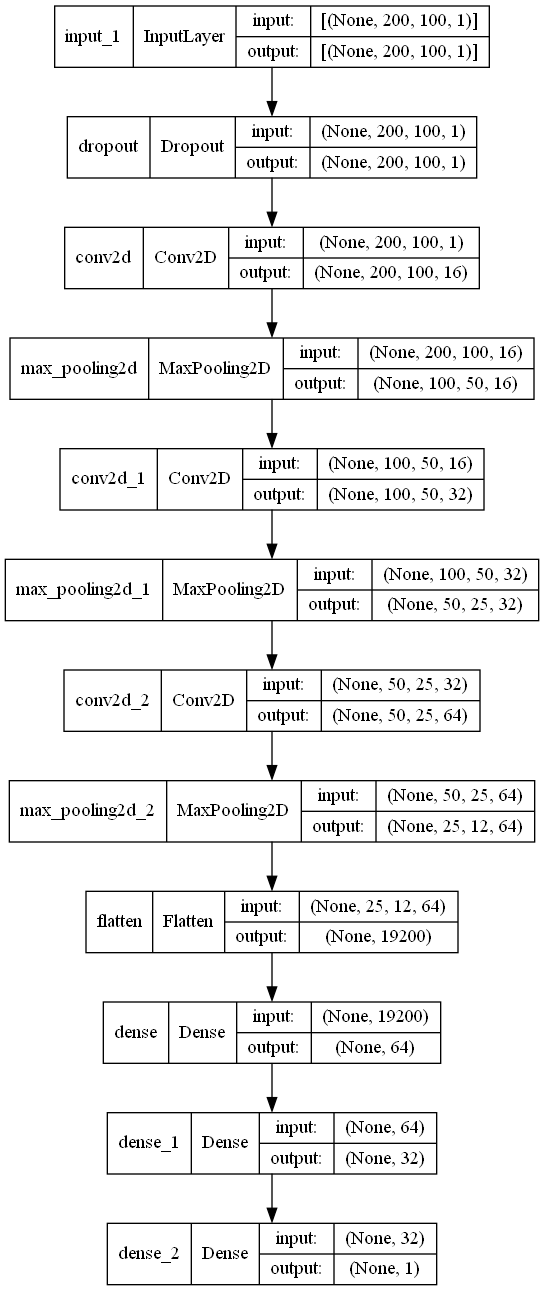

In [6]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

In [7]:
train_vectors.shape , train_labels.shape

((25000, 200, 100), (25000, 1))

In [8]:
train_vectors = train_vectors.reshape((25000,200,100,1))

In [9]:
history = model.fit(train_vectors, train_labels, batch_size=64, epochs=6, validation_split=0.1)

Epoch 1/6
352/352 [==============================] - 14s 26ms/step - loss: 0.5834 - accuracy: 0.6745 - val_loss: 0.4717 - val_accuracy: 0.7736
Epoch 2/6
352/352 [==============================] - 6s 18ms/step - loss: 0.4308 - accuracy: 0.8031 - val_loss: 0.4082 - val_accuracy: 0.8136
Epoch 3/6
352/352 [==============================] - 7s 19ms/step - loss: 0.3807 - accuracy: 0.8311 - val_loss: 0.3685 - val_accuracy: 0.8348
Epoch 4/6
352/352 [==============================] - 7s 19ms/step - loss: 0.3564 - accuracy: 0.8456 - val_loss: 0.3645 - val_accuracy: 0.8388
Epoch 5/6
352/352 [==============================] - 6s 18ms/step - loss: 0.3349 - accuracy: 0.8550 - val_loss: 0.3559 - val_accuracy: 0.8404
Epoch 6/6
352/352 [==============================] - 7s 19ms/step - loss: 0.3212 - accuracy: 0.8618 - val_loss: 0.3543 - val_accuracy: 0.8460


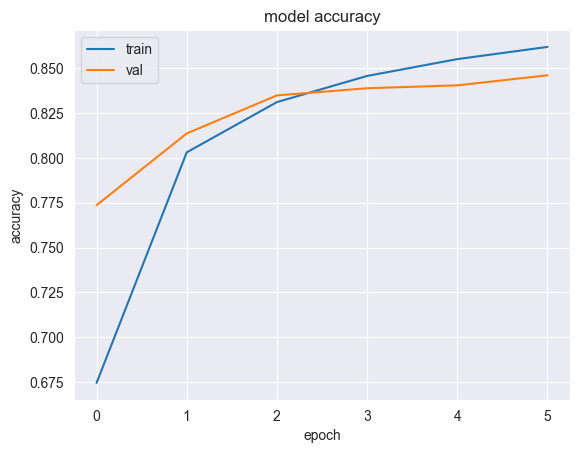

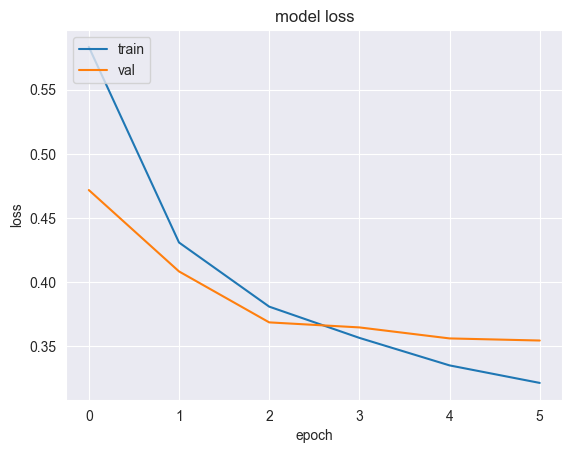

In [10]:
plot_accuracy_loss(history)

In [11]:
model.save_weights("weights2/cnn/cnn_weights")
model.save('cnn_model.h5')

save model

In [ ]:
savedModel = load_model('cnn_model.h5')
savedModel.summary()

load model and test data

In [5]:
savedModel = load_model('cnn_model.h5')
savedModel.summary()
test_vectors = np.load("testVectors.npy")
test_labels = np.load("testLabel.npy")

test_vectors = test_vectors.reshape((25000,200,100,1))

test_vectors.shape, test_labels.shape

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 200, 100, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 100, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 50, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 50, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 25, 64)        1

((25000, 200, 100, 1), (25000, 1))

In [6]:
preds = savedModel.predict(test_vectors)
preds = [0 if row < 0.50 else 1 for row in preds]
preds

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,


              precision    recall  f1-score   support

           0       0.90      0.85      0.88     12500
           1       0.86      0.91      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

******
accuracy model 87.992 % 
 

confusion_matrix 



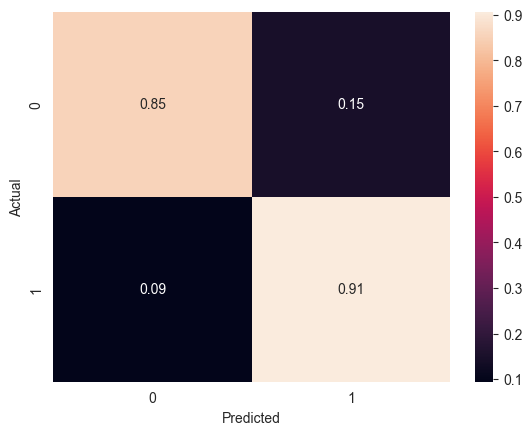

In [7]:
show_report_model(test_labels, preds)